0. Load the Data

In [4]:
from pandas import read_csv
df = read_csv("C:/Users/qhaskovec/OneDrive/GitHub/PhD-Thesis-EU-Solidarity-Statements/EUSpeech_translated_preprocessed_not_about_self.csv")

1. Descriptive Statistics

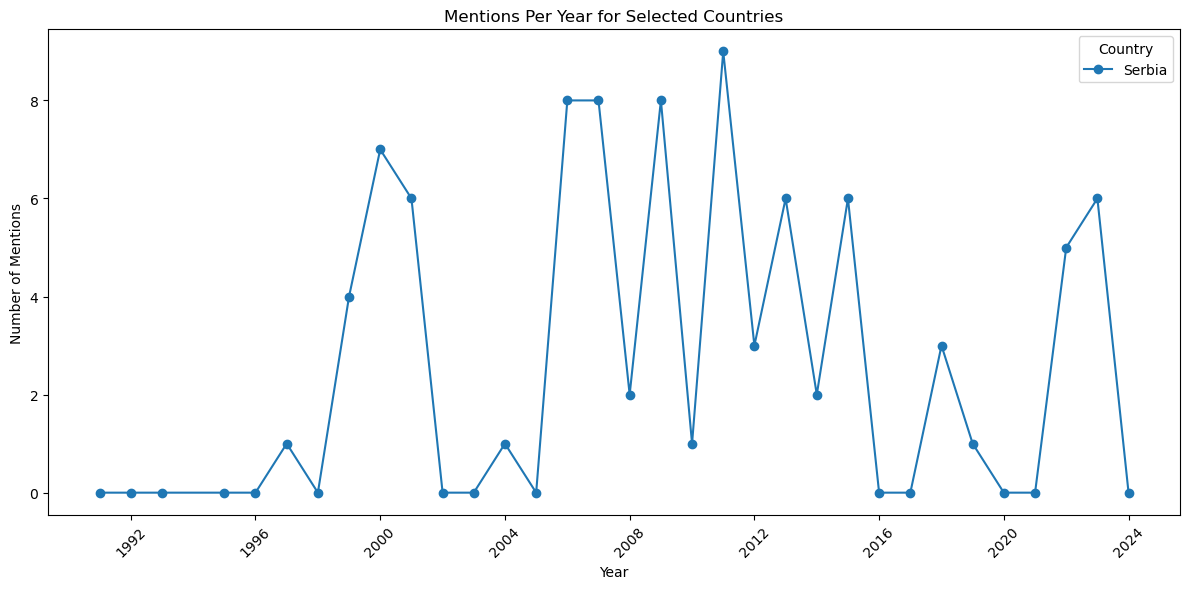

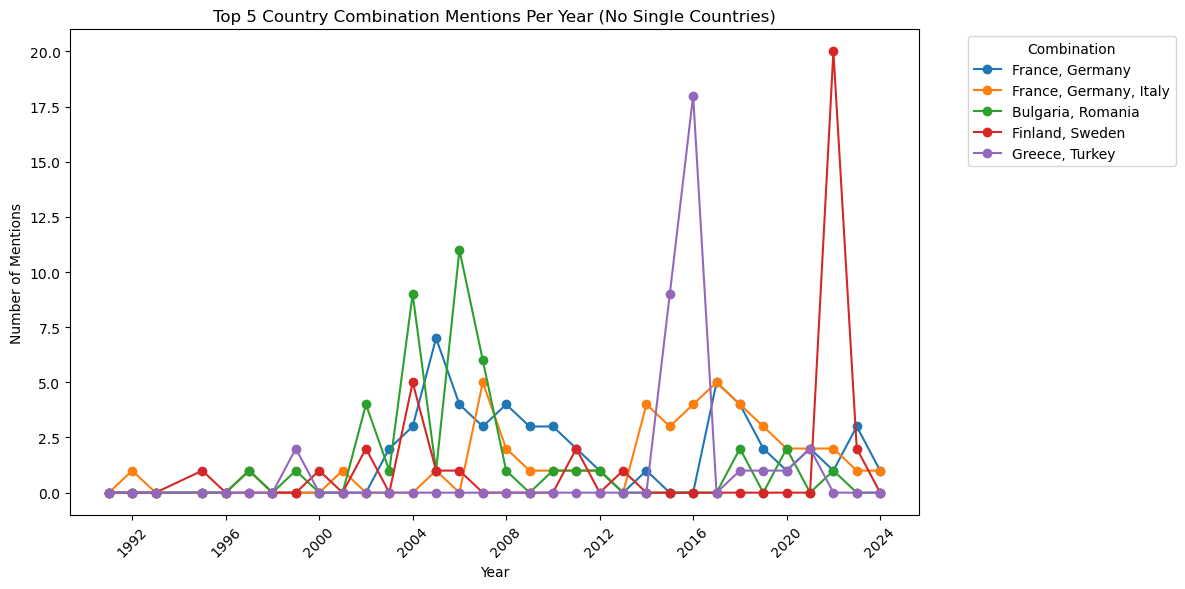

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Prepare the data ---
# Ensure that the date column is in datetime format.
df["date"] = pd.to_datetime(df["date"])

# -------------------------------
# Plot 1: Mentions of individual countries per month
# -------------------------------

# Split "matched_keyword" into lists and explode
df_exploded = df.copy()
df_exploded["country"] = df_exploded["matched_keyword"].str.split(r",\s*")
df_exploded = df_exploded.explode("country")

# Group by year and country
individual_counts = (
    df_exploded.groupby([df_exploded["date"].dt.to_period("Y").dt.to_timestamp(), "country"])
               .size()
               .unstack(fill_value=0)
)

# 🔍 Filter to selected countries
selected_countries = ["Serbia"]  # change as needed
filtered_counts = individual_counts[selected_countries]

# Plot
plt.figure(figsize=(12, 6))
for country in selected_countries:
    plt.plot(filtered_counts.index, filtered_counts[country], marker="o", label=country)
plt.xlabel("Year")
plt.ylabel("Number of Mentions")
plt.title("Mentions Per Year for Selected Countries")
plt.xticks(rotation=45)
plt.legend(title="Country")
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2: Mentions of country combinations per month
# -------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import re

# Helper function: sort the countries in the combination so that order does not matter.
def sorted_combination(matched):
    if pd.isna(matched):
        return None
    countries = [x.strip() for x in matched.split(",") if x.strip() != ""]
    if not countries:
        return None
    return ", ".join(sorted(countries))

# Create a new column for the sorted combination.
df["combination"] = df["matched_keyword"].apply(sorted_combination)

# Filter out single-country combinations (those without a comma).
df_multi = df[df["combination"].apply(lambda x: x is not None and "," in x)]

# Group by year and combination.
combination_counts = (
    df_multi.groupby([df_multi["date"].dt.to_period("Y").dt.to_timestamp(), "combination"])
          .size()
          .unstack(fill_value=0)
)

# Select the top 5 most common combinations overall.
top_combinations = combination_counts.sum().sort_values(ascending=False).head(5).index
combination_counts_top = combination_counts[top_combinations]

# Plot the top 5 combinations over time (by year).
plt.figure(figsize=(12, 6))
for combo in combination_counts_top.columns:
    plt.plot(combination_counts_top.index, combination_counts_top[combo], marker="o", label=combo)
plt.xlabel("Year")
plt.ylabel("Number of Mentions")
plt.title("Top 5 Country Combination Mentions Per Year (No Single Countries)")
plt.xticks(rotation=45)
plt.legend(title="Combination", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()




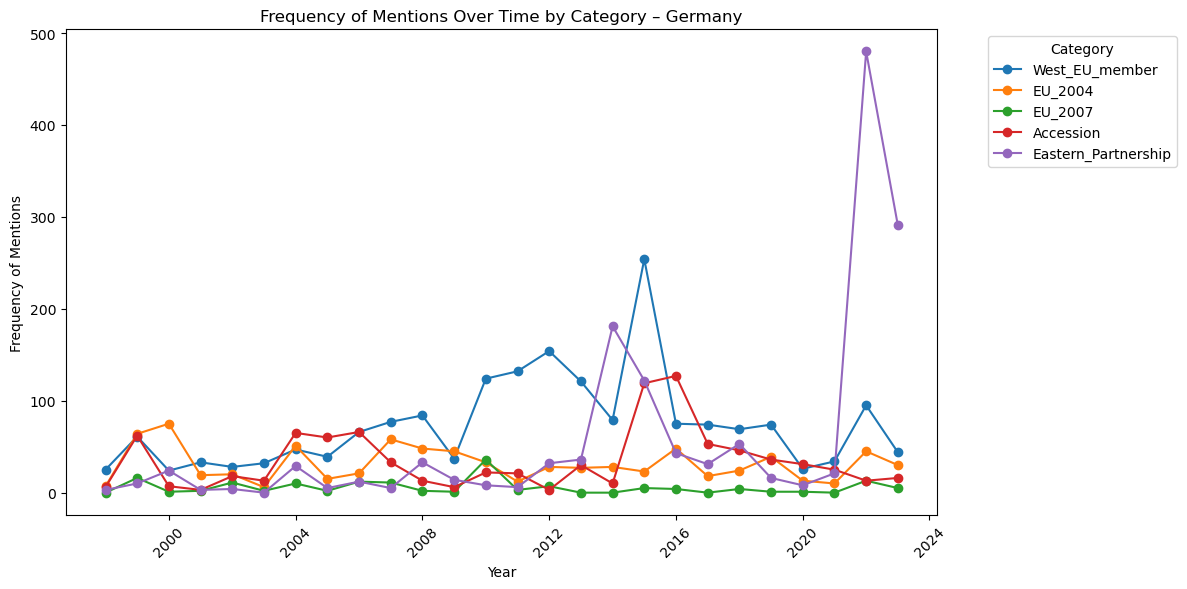

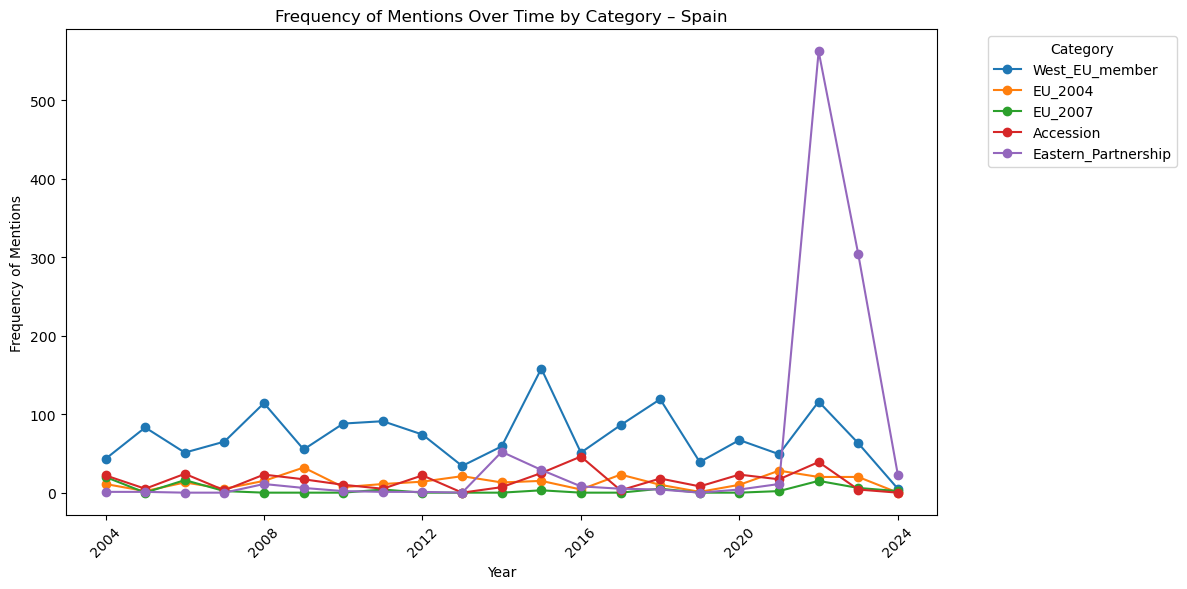

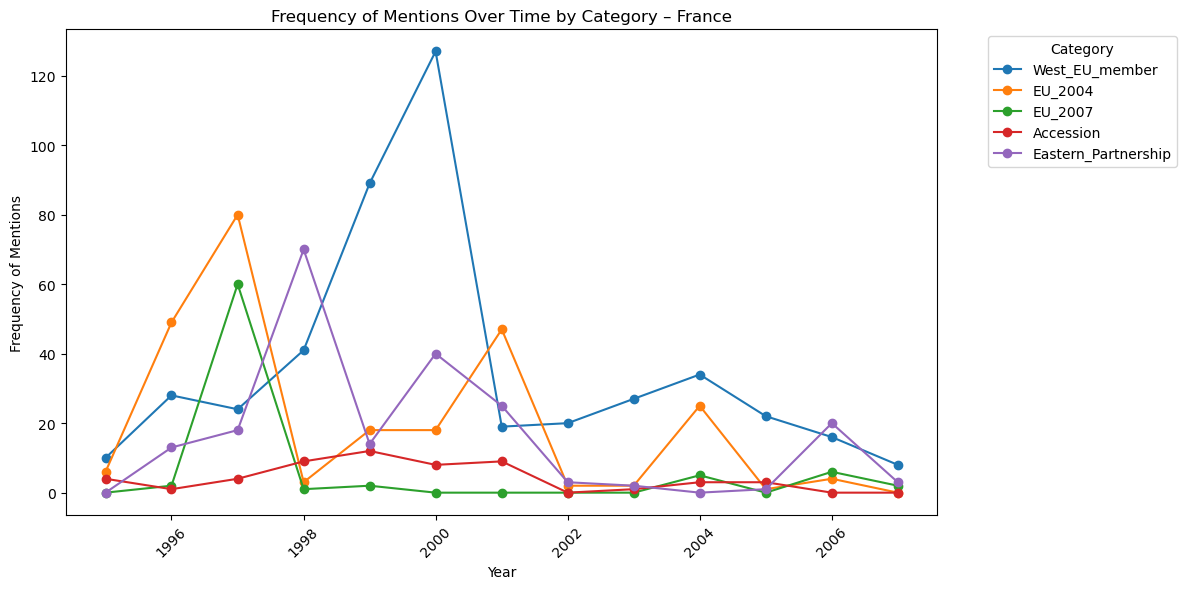

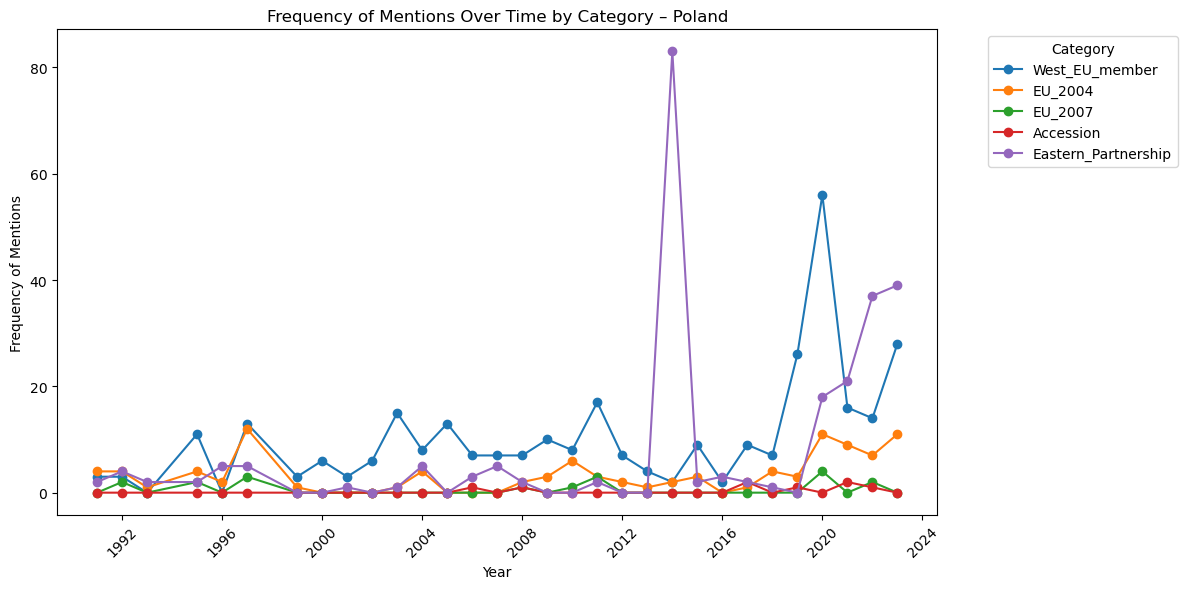

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the "date" column is in datetime format.
df["date"] = pd.to_datetime(df["date"])

# Categories we want to count mentions for.
categories = ["West_EU_member", "EU_2004", "EU_2007", "Accession", "Eastern_Partnership"]

# Define a function to count relevant items per row.
def count_category(row, cat):
    if not isinstance(row.get(cat, ""), str) or not row[cat].strip():
        return 0
    items = [k.strip() for k in row[cat].split(",") if k.strip()]
    if cat in ["EU_member", "West_EU_member", "EU_2004"]:
        own_country = row.get("country", "").strip().lower() if isinstance(row.get("country", ""), str) else ""
        items = [k for k in items if k.lower() != own_country]
    return len(items)

# Compute count columns for each category.
for cat in categories:
    if cat in ["EU_member", "West_EU_member", "EU_2004"]:
        df[cat + "_count"] = df.apply(lambda row: count_category(row, cat), axis=1)
    else:
        df[cat + "_count"] = df[cat].apply(
            lambda x: len(x.split(",")) if isinstance(x, str) and x.strip() != "" else 0
        )

# Get all unique countries
unique_countries = df["country"].dropna().unique()

# Loop through each country and create a frequency plot
for country in unique_countries:
    df_country = df[df["country"] == country]

    if df_country.empty:
        continue

    # Aggregate the counts per year
    agg_counts = {}
    for cat in categories:
        grouped = df_country.groupby(df_country["date"].dt.to_period("Y").dt.to_timestamp())[cat + "_count"].sum()
        agg_counts[cat] = grouped

    # Combine the aggregated counts into one DataFrame.
    agg_df = pd.DataFrame(agg_counts)

    # Plot raw frequency counts for each category.
    plt.figure(figsize=(12, 6))
    for cat in categories:
        plt.plot(agg_df.index, agg_df[cat], marker='o', label=cat)
    plt.xlabel("Year")
    plt.ylabel("Frequency of Mentions")
    plt.title(f"Frequency of Mentions Over Time by Category – {country}")
    plt.xticks(rotation=45)
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
